In [1]:
import numpy as np
from doctr.models import ocr_predictor, detection_predictor, recognition_predictor, kie_predictor
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
plt.rcParams["figure.figsize"] = (20,20)

In [29]:
import doctr
from doctr.io import DocumentFile

from shapely import LineString
import shapely
from operator import itemgetter 

In [5]:
model = detection_predictor(pretrained=True)
docs = DocumentFile.from_images(["dvurog_p007.png"])
img = cv2.imread("dvurog_p007.png")
img_h, img_w, _ = img.shape

In [6]:
result = model(docs)
words = result[0]["words"]
words[:,0]  = (words[:,0] * img_w).astype(np.int32)
words[:,1]  = (words[:,1] * img_h).astype(np.int32)
words[:,2]  = (words[:,2] * img_w).astype(np.int32)
words[:,3]  = (words[:,3] * img_h).astype(np.int32)
words = words.astype(np.int32)

In [7]:
words

array([[ 812, 2227,  838, 2265,    0],
       [1388, 2165, 1467, 2210,    0],
       [1300, 2165, 1381, 2203,    0],
       ...,
       [ 474,  128,  786,  178,    0],
       [ 379,  133,  457,  169,    0],
       [ 238,  123,  364,  169,    0]], shape=(380, 5), dtype=int32)

In [401]:
for word in words:
    xmin,ymin,xmax,ymax,_ = word
    cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 2)

In [11]:
def left_margin(filename):
    img = cv2.imread(filename)
    img_h, img_w, _ = img.shape
    
    model = detection_predictor(pretrained=True)
    docs = DocumentFile.from_images([filename])
    left_points = np.array([[xmin, (ymin + ymax) / 2] for xmin,ymin,xmax,ymax,_ in words])
    right_points = np.array([[xmax, (ymin + ymax) / 2] for xmin,ymin,xmax,ymax,_ in words])
    
    points = np.vstack((left_points, right_points))
    
    left_point_to_word = dict([((xmin, (ymin + ymax) / 2), (xmin,ymin,xmax,ymax)) for xmin,ymin,xmax,ymax,_ in words])
    right_point_to_word = dict([((xmax, (ymin + ymax) / 2), (xmin,ymin,xmax,ymax)) for xmin,ymin,xmax,ymax,_ in words])
    
    point_to_word = left_point_to_word | right_point_to_word
    
    kdtree = KDTree(points)
    dists, inds = kdtree.query(left_points,k=50)
    img = cv2.imread(filename)
    
    for nbs_inds in inds:
        p_ind = nbs_inds[0]
        nbs_inds = nbs_inds[1:]
        nbs = points[nbs_inds]
        x,y = points[p_ind]
        xmin1,ymin1,xmax1,ymax1 = point_to_word[(x,y)]
        points_to_left = []
        for nb in nbs:
            xmin,ymin,xmax,ymax = point_to_word[(nb[0],nb[1])]
            ls1 = LineString([(0,ymin),(0,ymax)])
            ls2 = LineString([(0,ymin1),(0,ymax1)])
            s = shapely.intersection(ls1,ls2)
            if nb[0] < x and not s.is_empty and s.length > (ymax-ymin)/2:
                points_to_left.append((nb[0],nb[1]))
        if len(points_to_left) == 0:
            cv2.rectangle(img, (int(x),int(y)), (int(x),int(y)), (255,0,0), 10)
    return img
            
        
        
    
    

In [14]:
def right_margin(filename):
    img = cv2.imread(filename)
    img_h, img_w, _ = img.shape
    
    model = detection_predictor(pretrained=True)
    docs = DocumentFile.from_images([filename])
    left_points = np.array([[xmin, (ymin + ymax) / 2] for xmin,ymin,xmax,ymax,_ in words])
    right_points = np.array([[xmax, (ymin + ymax) / 2] for xmin,ymin,xmax,ymax,_ in words])
    
    points = np.vstack((left_points, right_points))
    
    left_point_to_word = dict([((xmin, (ymin + ymax) / 2), (xmin,ymin,xmax,ymax)) for xmin,ymin,xmax,ymax,_ in words])
    right_point_to_word = dict([((xmax, (ymin + ymax) / 2), (xmin,ymin,xmax,ymax)) for xmin,ymin,xmax,ymax,_ in words])
    
    point_to_word = left_point_to_word | right_point_to_word
    
    kdtree = KDTree(points)
    dists, inds = kdtree.query(right_points,k=50)
    img = cv2.imread(filename)
    
    for nbs_inds in inds:
        p_ind = nbs_inds[0]
        nbs_inds = nbs_inds[1:]
        nbs = points[nbs_inds]
        x,y = points[p_ind]
        xmin1,ymin1,xmax1,ymax1 = point_to_word[(x,y)]
        points_to_left = []
        for nb in nbs:
            xmin,ymin,xmax,ymax = point_to_word[(nb[0],nb[1])]
            ls1 = LineString([(0,ymin),(0,ymax)])
            ls2 = LineString([(0,ymin1),(0,ymax1)])
            s = shapely.intersection(ls1,ls2)
            if nb[0] > x and not s.is_empty and s.length > (ymax-ymin)/2:
                points_to_left.append((nb[0],nb[1]))
        if len(points_to_left) == 0:
            cv2.rectangle(img, (int(x),int(y)), (int(x),int(y)), (255,0,0), 10)
    return img

In [44]:
filename = "dvurog_p007.png"
img = cv2.imread(filename)
img_h, img_w, _ = img.shape
    
model = detection_predictor(pretrained=True)
docs = DocumentFile.from_images([filename])

result = model(docs)
words = result[0]["words"]
words[:,0]  = (words[:,0] * img_w).astype(np.int32)
words[:,1]  = (words[:,1] * img_h).astype(np.int32)
words[:,2]  = (words[:,2] * img_w).astype(np.int32)
words[:,3]  = (words[:,3] * img_h).astype(np.int32)
words = words.astype(np.int32)

def margins(words):
    left_margin = []
    right_margin = []
    left_points = np.array([[xmin, (ymin + ymax) / 2] for xmin,ymin,xmax,ymax,_ in words])
    right_points = np.array([[xmax, (ymin + ymax) / 2] for xmin,ymin,xmax,ymax,_ in words])
    
    points = np.vstack((left_points, right_points))
    
    left_point_to_word = dict([((xmin, (ymin + ymax) / 2), (xmin,ymin,xmax,ymax)) for xmin,ymin,xmax,ymax,_ in words])
    right_point_to_word = dict([((xmax, (ymin + ymax) / 2), (xmin,ymin,xmax,ymax)) for xmin,ymin,xmax,ymax,_ in words])
    
    point_to_word = left_point_to_word | right_point_to_word
    
    kdtree = KDTree(points)
    dists_left, inds_left = kdtree.query(left_points,k=50)
    dists_right, inds_right = kdtree.query(right_points,k=50)
    
    for nbs_inds in inds_left:
        p_ind = nbs_inds[0]
        nbs_inds = nbs_inds[1:]
        nbs = points[nbs_inds]
        x,y = points[p_ind]
        xmin1,ymin1,xmax1,ymax1 = point_to_word[(x,y)]
        points_to_side = []
        for nb in nbs:
            xmin,ymin,xmax,ymax = point_to_word[(nb[0],nb[1])]
            ls1 = LineString([(0,ymin),(0,ymax)])
            ls2 = LineString([(0,ymin1),(0,ymax1)])
            s = shapely.intersection(ls1,ls2)
            if nb[0] < x and not s.is_empty and s.length > (ymax-ymin)/2:
                points_to_side.append((nb[0],nb[1]))
        if len(points_to_side) == 0:
            left_margin.append((int(x),int(y)))
            #cv2.rectangle(img, (int(x),int(y)), (int(x),int(y)), (255,0,0), 10)
    for nbs_inds in inds_right:
        p_ind = nbs_inds[0]
        nbs_inds = nbs_inds[1:]
        nbs = points[nbs_inds]
        x,y = points[p_ind]
        xmin1,ymin1,xmax1,ymax1 = point_to_word[(x,y)]
        points_to_side = []
        for nb in nbs:
            xmin,ymin,xmax,ymax = point_to_word[(nb[0],nb[1])]
            ls1 = LineString([(0,ymin),(0,ymax)])
            ls2 = LineString([(0,ymin1),(0,ymax1)])
            s = shapely.intersection(ls1,ls2)
            if nb[0] > x and not s.is_empty and s.length > (ymax-ymin)/2:
                points_to_side.append((nb[0],nb[1]))
        if len(points_to_side) == 0:
            right_margin.append((int(x),int(y)))
            #cv2.rectangle(img, (int(x),int(y)), (int(x),int(y)), (255,0,0), 10)
     

    return sorted(left_margin, key=itemgetter(1)), sorted(right_margin, key=itemgetter(1))
    




In [45]:
left_margin, right_margin = margins(words)

In [46]:
img = cv2.imread("dvurog_p007.png")
for l, r in zip(left_margin, right_margin):
    cv2.line(img, l, r, (255,0,0), 5)
    
    

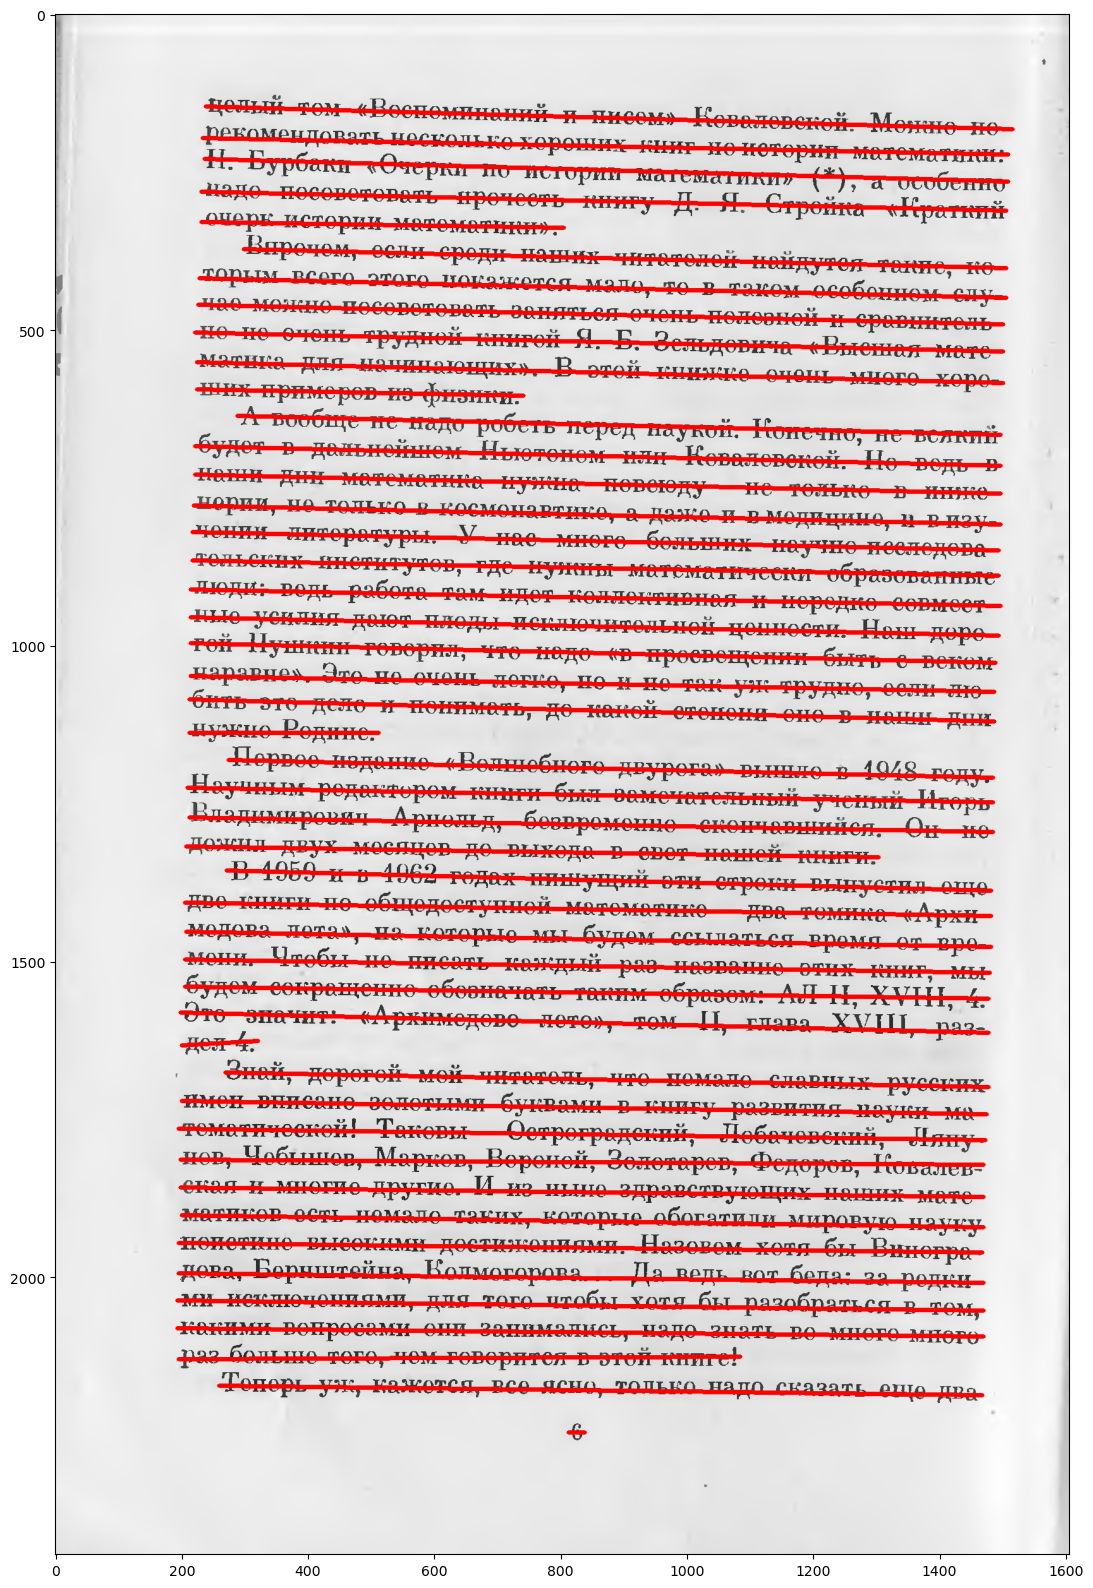

In [47]:
plt.imshow(img)

In [40]:
right_margin[0]

(1515, 182)

In [10]:
left_points = np.array([[xmin, (ymin + ymax) / 2] for xmin,ymin,xmax,ymax,_ in words])
right_points = np.array([[xmax, (ymin + ymax) / 2] for xmin,ymin,xmax,ymax,_ in words])

points = np.vstack((left_points, right_points))

left_point_to_word = dict([((xmin, (ymin + ymax) / 2), (xmin,ymin,xmax,ymax)) for xmin,ymin,xmax,ymax,_ in words])
right_point_to_word = dict([((xmax, (ymin + ymax) / 2), (xmin,ymin,xmax,ymax)) for xmin,ymin,xmax,ymax,_ in words])

point_to_word = left_point_to_word | right_point_to_word

kdtree = KDTree(points)

In [15]:
img = right_margin("dvurog_p007.png")

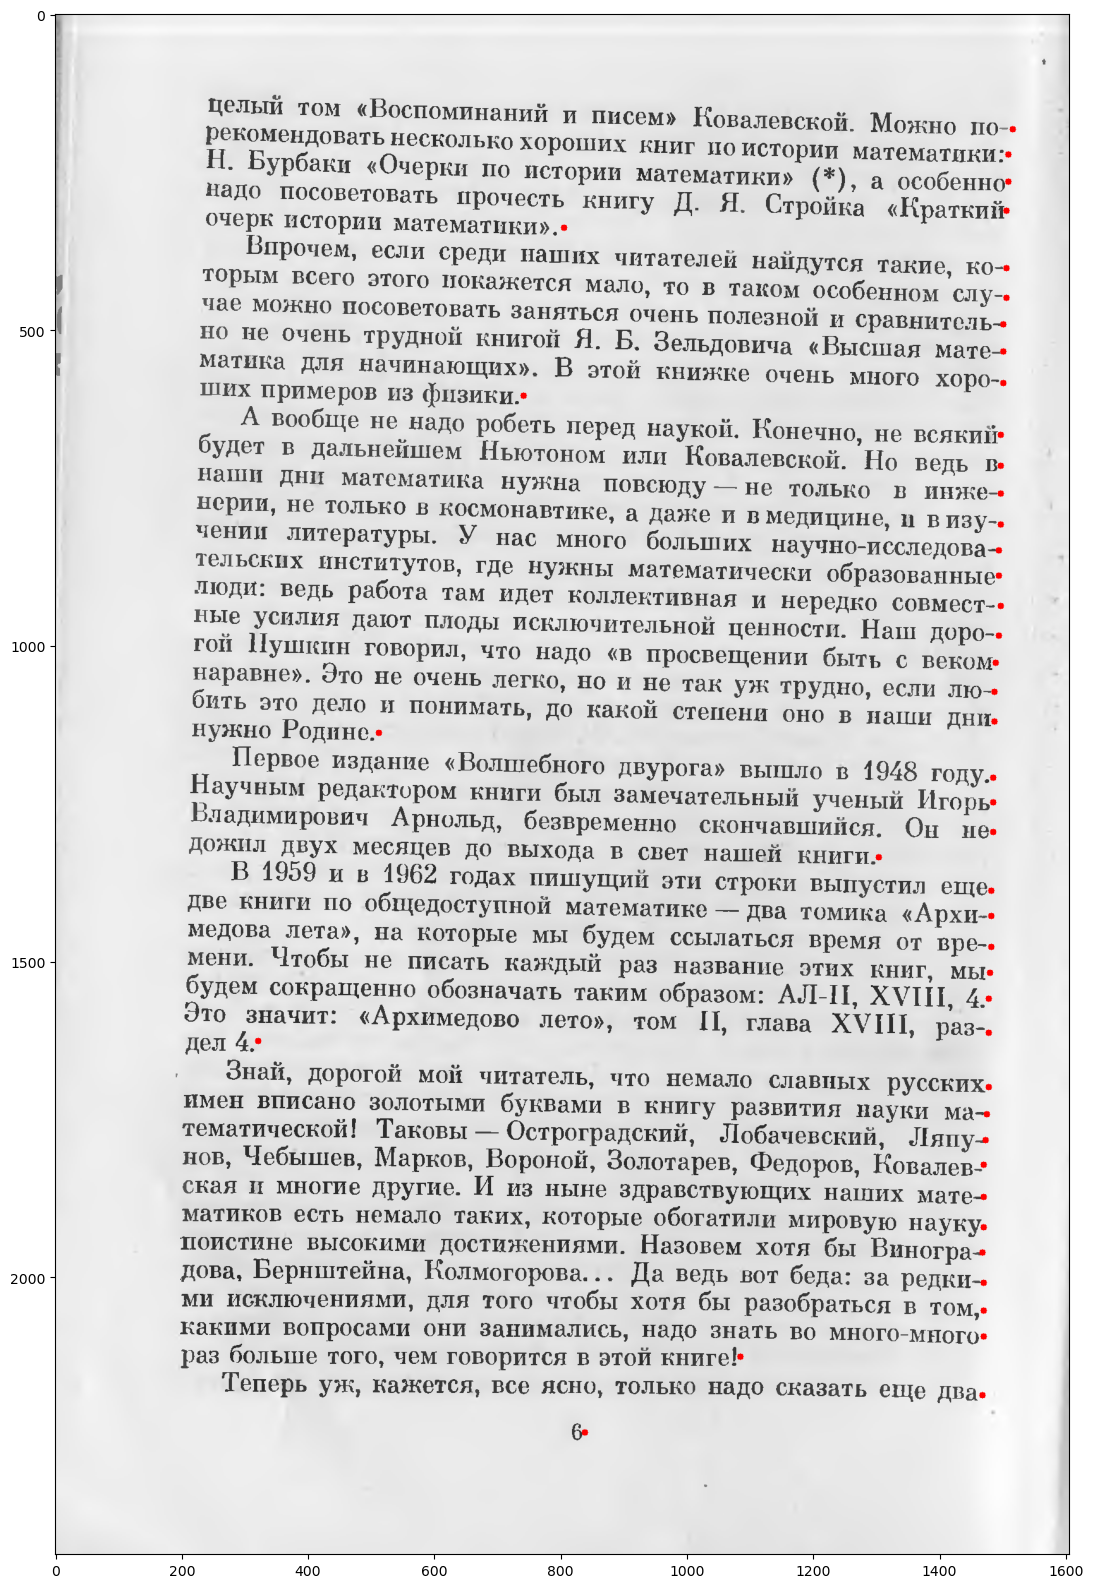

In [16]:
plt.imshow(img)

In [337]:
shapely.intersection(LineString([(0,0),(0,3)]), LineString([(0,0),(0,3)])).is_empty

False

In [433]:
dists, inds = kdtree.query(left_points,k=40)
inds[295]

array([295, 675, 298, 294, 679, 665, 299, 285, 284, 656, 308, 664, 276,
       688, 275, 283, 307, 317, 698, 697, 316, 318, 647, 267, 266, 655,
       325, 706, 326, 274, 634, 646, 687, 254, 265, 674, 305, 293, 252,
       696])

In [428]:
img = cv2.imread("dvurog_p007.png")
p_ind = 369
nbs_inds = inds[p_ind][1:]

nbs = points[nbs_inds]
x,y = points[p_ind]
xmin1,ymin1,xmax1,ymax1 = point_to_word[(x,y)]
print(xmin1,ymin1,xmax1,ymax1)
print("____")
cv2.rectangle(img, (int(xmin1),int(ymin1)), (int(xmax1),int(ymax1)), (0,255,0), 5)

points_to_left = []
for nb in nbs:
    print(nb)
    xmin,ymin,xmax,ymax = point_to_word[(nb[0],nb[1])]
    print(xmin,ymin,xmax,ymax)
    cv2.rectangle(img, (int(xmin),int(ymin)), (int(xmax),int(ymax)), (255,0,0), 5)
    ls1 = LineString([(0,ymin),(0,ymax)])
    ls2 = LineString([(0,ymin1),(0,ymax1)])
    s = shapely.intersection(ls1,ls2)
    print("length")
    print(s.length)
    if nb[0] < x and not s.is_empty:
        #print(f"(x,y) = ({x}, {y})")
        points_to_left.append((nb[0],nb[1]))
if len(points_to_left) == 0:
    print(x,y)
    print("empty")
    #cv2.rectangle(img, (int(x),int(y)), (int(x),int(y)), (255,0,0), 10)
    pass

731 188 910 231
____
[731. 202.]
526 181 731 223
length
35.0
[726.  248.5]
669 231 726 266
length
0.0
[738.  254.5]
738 233 900 276
length
0.0
[669.  248.5]
669 231 726 266
length
0.0
[660.  243.5]
488 216 660 271
length
15.0
[786. 153.]
474 128 786 178
length
0.0
[798.  162.5]
798 147 831 178
length
0.0
[831.  162.5]
798 147 831 178
length
0.0
[812. 296.]
631 273 812 319
length
0.0
[845. 165.]
845 147 986 183
length
0.0
[631. 296.]
631 273 812 319
length
0.0
[829.  303.5]
829 281 955 326
length
0.0
[612.  287.5]
350 266 612 309
length
0.0
[805. 338.]
526 312 805 364
length
0.0
[731. 384.]
731 366 867 402
length
0.0
[900.  254.5]
738 233 900 276
length
0.0
[719.  384.5]
602 362 719 407
length
0.0
[910.  209.5]
731 188 910 231
length
43.0
[914. 258.]
914 238 1174 278
length
0.0


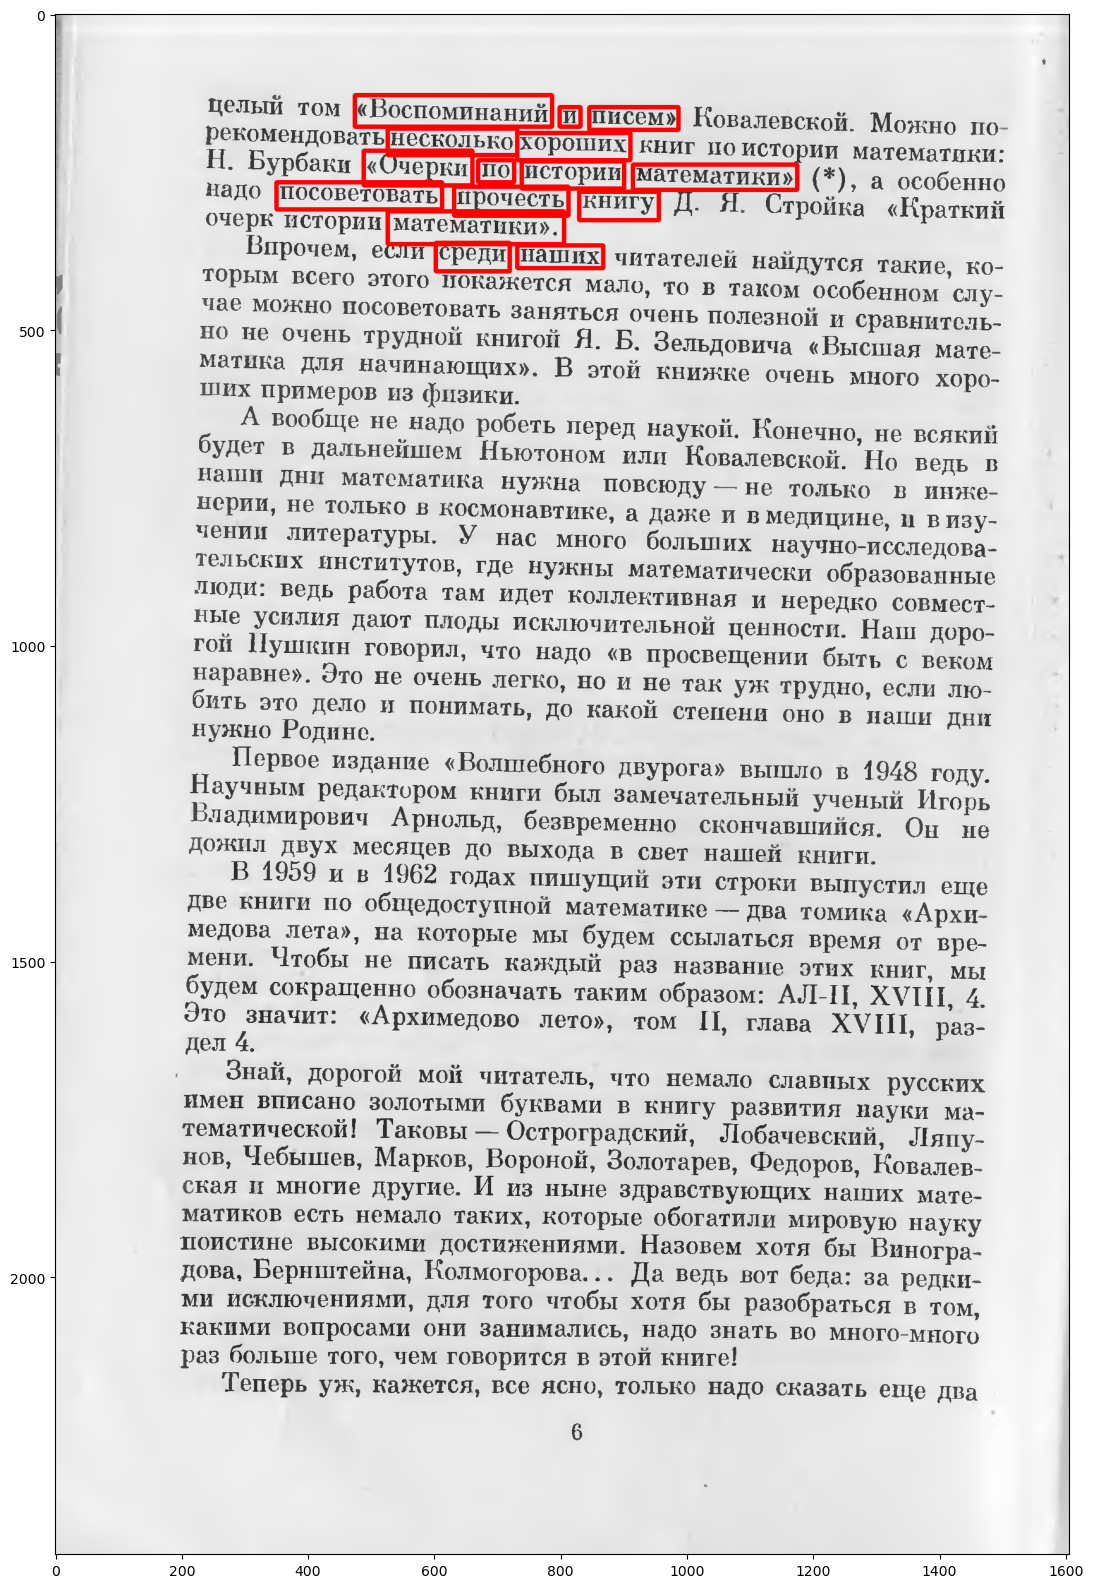

In [429]:
plt.imshow(img)

In [436]:
## Description
## find nearest neighbors
## if no rectangles are to the left so that intersection is not empty and the intersecrtion length > half height
dists, inds = kdtree.query(left_points,k=50)
img = cv2.imread("dvurog_p007.png")
img_h, img_w, _ = img.shape
first_points = []
for nbs_inds in inds:
    p_ind = nbs_inds[0]
    nbs_inds = nbs_inds[1:]
    nbs = points[nbs_inds]
    x,y = points[p_ind]
    xmin1,ymin1,xmax1,ymax1 = point_to_word[(x,y)]
    points_to_left = []
    for nb in nbs:
        xmin,ymin,xmax,ymax = point_to_word[(nb[0],nb[1])]
        ls1 = LineString([(0,ymin),(0,ymax)])
        ls2 = LineString([(0,ymin1),(0,ymax1)])
        s = shapely.intersection(ls1,ls2)
        if nb[0] < x and not s.is_empty and s.length > (ymax-ymin)/2:
            #print(f"(x,y) = ({x}, {y})")
            points_to_left.append((nb[0],nb[1]))
    if len(points_to_left) == 0:
        print(p_ind)
        print(x,y)
        cv2.rectangle(img, (int(x),int(y)), (int(x),int(y)), (255,0,0), 10)
        
        
        
        
        

0
812.0 2246.0
10
259.0 2172.0
15
195.0 2130.0
26
193.0 2081.5
35
193.0 2037.0
42
195.0 1994.0
52
195.0 1946.5
59
200.0 1902.5
68
198.0 1858.5
76
198.0 1814.5
82
195.0 1765.5
91
200.0 1721.5
99
269.0 1676.0
100
200.0 1633.0
110
198.0 1581.0
118
205.0 1540.5
127
205.0 1497.5
138
207.0 1453.5
146
205.0 1407.0
157
271.0 1356.0
166
207.0 1318.0
172
212.0 1272.5
179
209.0 1225.0
187
274.0 1181.0
188
212.0 1138.0
201
212.0 1085.5
213
214.0 1048.5
224
214.0 996.5
232
214.0 955.0
241
214.0 911.5
247
217.0 865.5
254
217.0 820.0
267
219.0 778.5
276
221.0 729.5
285
221.0 684.5
295
288.0 636.5
299
224.0 594.0
308
224.0 551.0
318
221.0 504.5
326
226.0 460.5
336
228.0 418.5
344
298.0 372.5
347
231.0 329.5
355
231.0 281.5
364
236.0 229.5
371
233.0 196.0
379
238.0 146.0


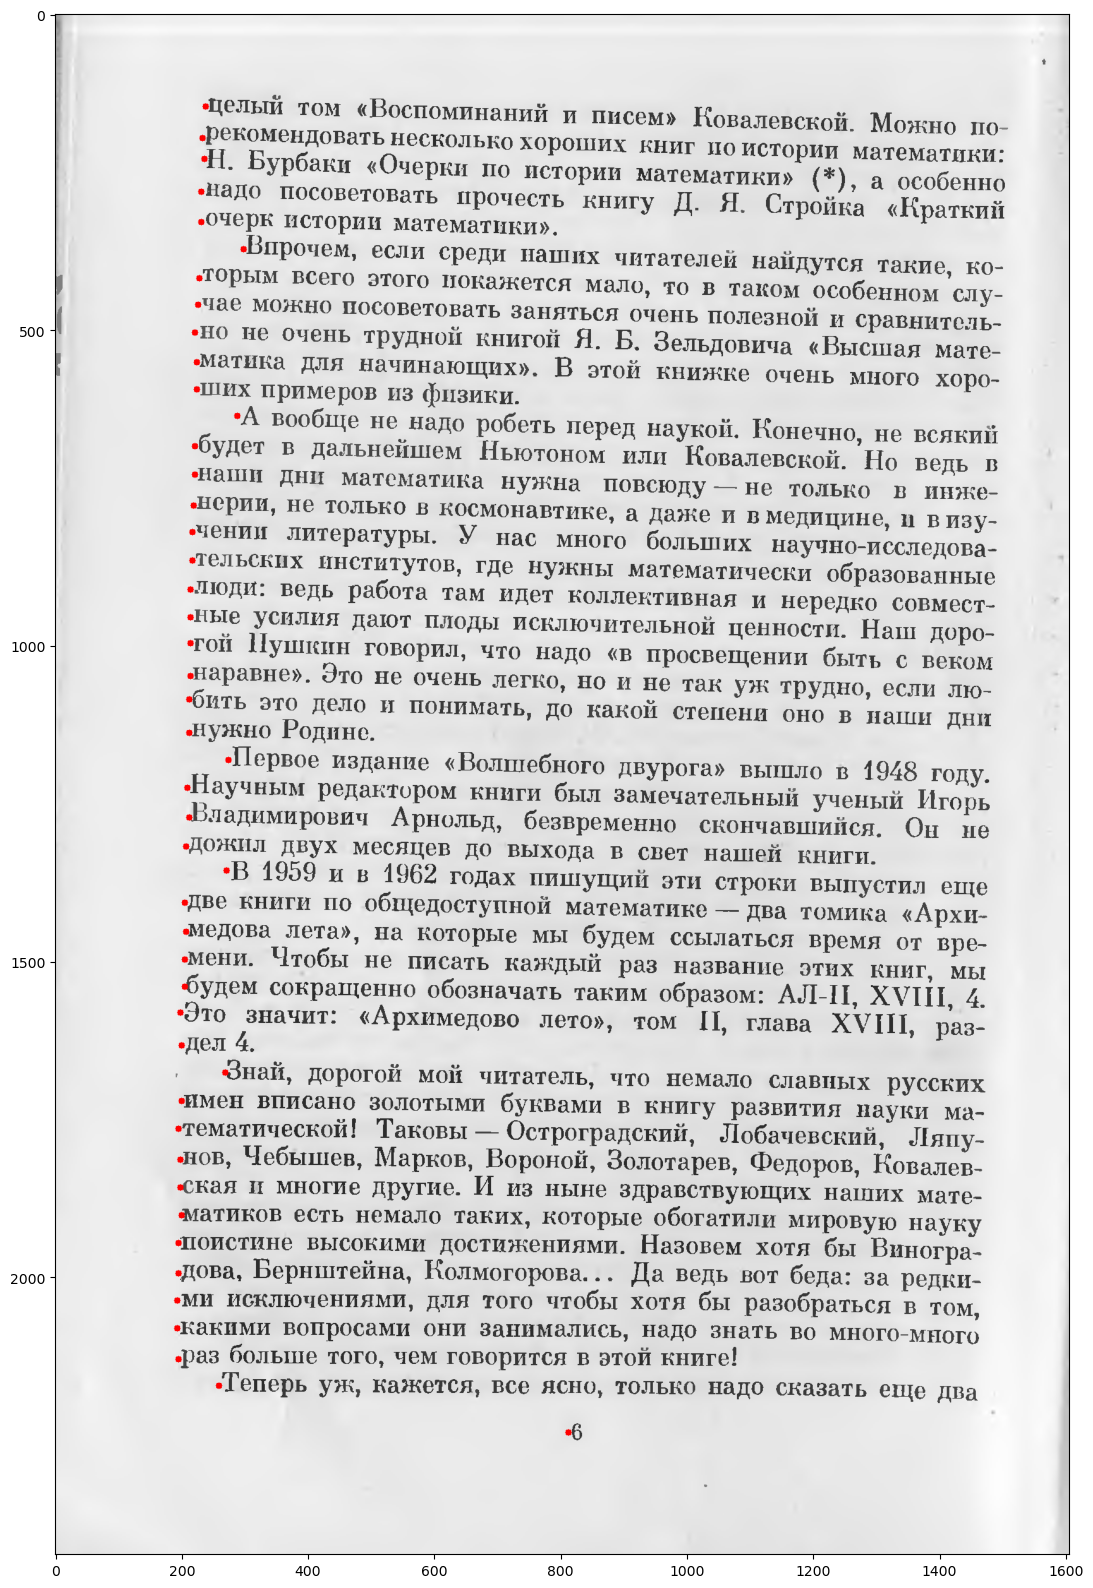

In [437]:
plt.imshow(img)